# Topic Clustering using NMF
By: Luis Chavez

## Problem Description
In this project we will focus on the unsupervised situation when the classes are not known and they need to be discovered via clustering. Clustering here can be done via the matrix factorisation technique NMF. The task of the project is to discover topics of department of justice press releases.

## Data Source
https://www.kaggle.com/jbencina/department-of-justice-20092018-press-releases/

## Example Implementation
https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45

In [1]:
#Importing required libraries
import nltk
import spacy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import NMF
from gensim.corpora.dictionary import Dictionary
from nltk.tokenize import word_tokenize
from gensim.models.nmf import Nmf
from gensim.models import CoherenceModel

#This might be needed in some systems where is not installed
#nltk.download('punkt')

## Data Load and Quality Check

In [2]:
#Reading content in a DataFrame
df = pd.read_json('combined.json',lines=True)
df.head()

,id,title,contents,date,topics,components
0,None,Convicted Bomb Plotter Sentenced to 30 Years,"PORTLAND, Oregon. – Mohamed Osman Mohamud, 23,...",2014-10-01T00:00:00-04:00,[],[National Security Division (NSD)]
1,12-919,$1 Million in Restitution Payments Announced t...,WASHINGTON – North Carolina’s Waccamaw River...,2012-07-25T00:00:00-04:00,[],[Environment and Natural Resources Division]
2,11-1002,$1 Million Settlement Reached for Natural Reso...,BOSTON– A $1-million settlement has been...,2011-08-03T00:00:00-04:00,[],[Environment and Natural Resources Division]
3,10-015,10 Las Vegas Men Indicted \r\nfor Falsifying V...,WASHINGTON—A federal grand jury in Las Vegas...,2010-01-08T00:00:00-05:00,[],[Environment and Natural Resources Division]
4,18-898,$100 Million Settlement Will Speed Cleanup Wor...,"The U.S. Department of Justice, the U.S. Envir...",2018-07-09T00:00:00-04:00,[Environment],[Environment and Natural Resources Division]


In [3]:
#Checking null values in the data
df.isnull().sum()

id            277
title           0
contents        0
date            0
topics          0
components      0
dtype: int64

In [4]:
#Removing some columns not needed
columns_to_keep = ['title','contents']
df = df[columns_to_keep]

After checking the data quality:
1. Found that the only relevant columns for our unsupervised learning NMF model are title and contents
2. There are no null values to fill in or remove. Only id column which has been already removed had null values

## Exploratory Data Analysis 

count    13087.000000
mean       575.597387
std        503.415802
min          0.000000
25%        348.000000
50%        490.000000
75%        687.000000
max      25254.000000
Name: word_count, dtype: float64


<AxesSubplot:xlabel='word_count'>

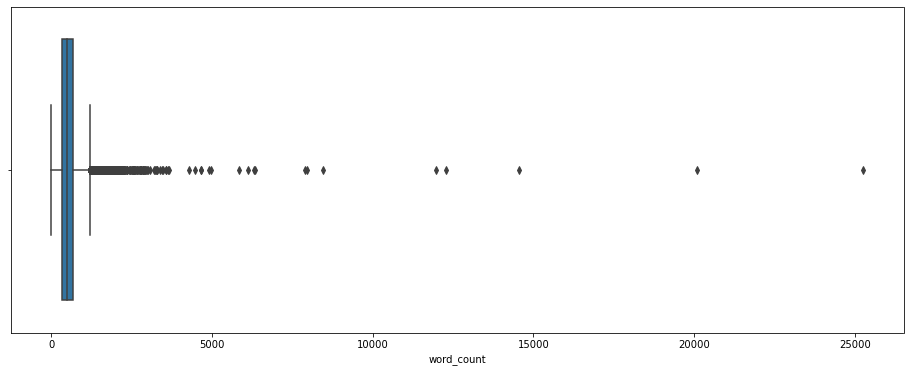

In [7]:
#Plotting and printing a summary of the word count
word_count = pd.DataFrame()
word_count['word_count'] = pd.Series([len(content.split()) for content in df['contents']]) 
plt.figure(figsize=(16, 6))
print(word_count['word_count'].describe())
sns.boxplot(data=word_count,x='word_count')

In [19]:
#There are an unsual number of outliers
#Checking some of the outliers to make sure they don't have noise data
#The reviewed texts are valid so we will not remove any of the outliers
outlier_mask = word_count['word_count'] > 1000
df_outliers = df[outlier_mask]
df_outliers.iloc[5].contents

'Federal authorities arrested Yi-Chi Shih, 62, and Kiet Ahn Mai, 63, on Jan. 19, on federal charges that allege a scheme to illegally obtain technology and integrated circuits with military applications that were exported to a Chinese company without the required export license. \xa0 The announcement was made by Acting Assistant Attorney General for National Security Dana J. Boente; U.S. Attorney Nicola T. Hanna for the Central District of California; Assistant Director in Charge Paul Delacourt of the FBI’s Los Angeles Field Office; Special Agent in Charge R. Damon Rowe of IRS Criminal Investigation; Special Agent in Charge Richard Weir of the U.S. Department of Commerce, Bureau of Industry and Security, Office of Export Enforcement, Los Angeles Field Office. \xa0 “According to the complaint, the defendants allegedly schemed to illegally export semiconductors having military and civilian applications to a Chinese company,” said Acting Assistant Attorney General Boente.\xa0 “Protecting 

In [20]:
#Using bag of words to check what are the most frequent words across all texts
corpus = df['contents']

# Create CountVectorizer object
vectorizer = CountVectorizer(strip_accents='ascii', 
                             stop_words='english', 
                             lowercase=True,    
                             min_df=3,
                             max_df=0.75,
                             token_pattern=r'[A-Za-z]+',
                             max_features=5000)

# Generate matrix of word vectors
bow_matrix = vectorizer.fit_transform(corpus)

<AxesSubplot:>

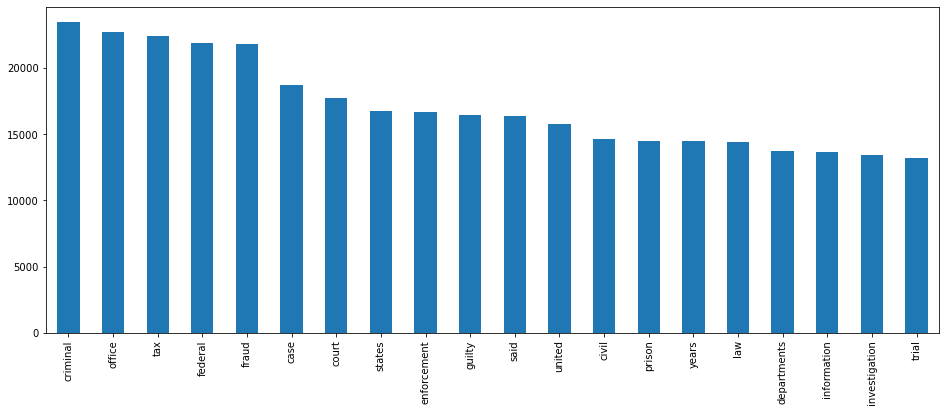

In [21]:
#Generating a DataFrame of the BoW to plot it
bow_df = pd.DataFrame(bow_matrix.toarray())
bow_df.columns = vectorizer.get_feature_names()

#Plotting the top 20 frequent words in the raw data
plt.figure(figsize=(16, 6))
top_20_words = bow_df.sum().sort_values(ascending=False)[:20]
top_20_words.plot.bar()

## Feature Engineering 

In [22]:
#Method to preprocess text to change it lowercase, remove stop words, lemmatize include only alpha words
def preprocess_text(text):
    # Generate list of tokens
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    
    #Defining stop words
    stopwords = spacy.lang.en.stop_words.STOP_WORDS
    
    preproc_lemmas = [lemma.lower() for lemma in lemmas if lemma.isalpha() and lemma not in stopwords]
    return ' '.join(preproc_lemmas)

In [23]:
#Generate a preproc_contents column where we apply the method we defined above
#The code may take some hours to execute. The resulting df was saved in 'preprocessed.csv' file for future use
#If needed to execute again uncomment these two lines of code
df['preproc_contents'] = df['contents'].apply(preprocess_text)
df.to_csv('preprocessed.csv')

#Load this file if don't want to preprocess everything again since it may take some hours
#df = pd.read_csv('preprocessed.csv')

## Machine Learning models

In [24]:
# Use Gensim's NMF to get the best num of topics via coherence score
texts = [word_tokenize(doc) for doc in df['preproc_contents']]

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 75 + 1, 5))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))

<AxesSubplot:xlabel='number of topics', ylabel='coherence score'>

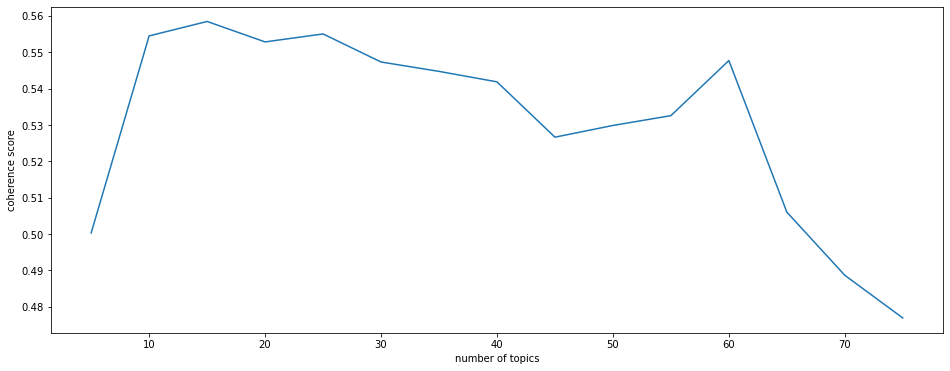

In [25]:
plt.figure(figsize=(16, 6))
coherence_results = pd.DataFrame()
coherence_results['number of topics'] = [x[0] for x in scores]
coherence_results['coherence score'] = [x[1] for x in scores]

sns.lineplot(data=coherence_results,x='number of topics',y='coherence score')

Based on the coherence score from the gensim NMF model, we determine that the best number of topics is 15

In [26]:
#Now that we have found the number of topics, we will generate a tf-idf matrix to feed a sklearn NMF model
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.85,    
    ngram_range=(1, 2),
    max_features=5000
)
tfidf = tfidf_vectorizer.fit_transform(df['preproc_contents'])

In [27]:
#Generating NMF from sklearn
nmf = NMF(n_components=15,init='nndsvd')
A = tfidf 
print('A: Documents by words matrix ({})'.format(A.shape))
W = nmf.fit_transform(tfidf)
print('W: Documents by topics matrix ({})'.format(W.shape))
H = nmf.components_
print('A: Topics by words matrix ({})'.format(H.shape))

print('Mathematical representation of the matrices: A = WxH')

A: Documents by words matrix ((13087, 5000))
W: Documents by topics matrix ((13087, 15))
A: Topics by words matrix ((15, 5000))
Mathematical representation of the matrices: A = WxH


In [28]:
#Create a DataFrame that maps the 15 topics (rows) and the importance of the words (columns)
topics_by_words = pd.DataFrame(H,columns=tfidf_vectorizer.get_feature_names())
topics_by_words.head()

,aaron,abbate,abbott,abet,abide,ability,able,abroad,abt,abu,...,york,york assistant,york city,york field,york state,young,youth,zazi,zone,zuckerman
0,0.012784,0.022610,0.000000,0.021042,0.016191,0.011779,0.023153,0.034699,0.0,0.000000,...,0.190961,0.009356,0.007336,0.042107,0.009528,0.029496,0.000000,0.0,0.006083,0.000000
1,0.000462,0.000000,0.000000,0.005473,0.002266,0.007828,0.002698,0.000000,0.0,0.000000,...,0.038572,0.000000,0.000840,0.000743,0.001472,0.001681,0.000000,0.0,0.000000,0.112762
2,0.000000,0.016215,0.008087,0.000274,0.000000,0.000168,0.002154,0.000000,0.0,0.000000,...,0.035889,0.005174,0.000000,0.006455,0.007578,0.013369,0.000000,0.0,0.000000,0.000000
3,0.000476,0.000270,0.000000,0.000000,0.000451,0.016738,0.008797,0.000000,0.0,0.001993,...,0.007346,0.000000,0.000403,0.000000,0.000000,0.000000,0.000000,0.0,0.054379,0.000000
4,0.000979,0.001389,0.000212,0.000000,0.000000,0.000000,0.006229,0.007020,0.0,0.000000,...,0.010546,0.000000,0.000074,0.000000,0.001362,0.080338,0.006411,0.0,0.000000,0.000000


In [46]:
#Define a method to get the top words in a provided topic
def get_top_words_in_topic(topic,n=8):
    return ','.join(topic.sort_values(ascending=False)[:n].index)

#Get the list of topics and the top words in each topic based on the method defined above
top_words_by_topic = topics_by_words.apply(get_top_words_in_topic,axis=1)
top_words_by_topic

0     fraud,criminal,criminal division,company,scheme,bank,money,district                           
1     tax,irs,tax return,tax division,return,income,refund,false                                    
2     medicare,health,fraud,care,hhs,health care,home health,oig                                    
3     housing,fair housing,fair,discrimination,housing act,hud,housing discrimination,disability    
4     child,child pornography,pornography,safe childhood,childhood,project safe,exploitation,project
5     health,care,false claims,claims act,claims,settlement,health care,false                       
6     tax,return,prepare,injunction,tax return,preparer,customer,complaint                          
7     antitrust,antitrust division,bid,price,auction,fine,foreclosure auction,conspiracy            
8     employment,discrimination,osc,ina,immigration,worker,citizenship,employer                     
9     epa,environmental,water,air,clean,settlement,emission,pollution                      

In [30]:
#Mapping topic ids and their top words into the original DataFrame
df['topic_id'] = np.argmax(W,axis=1)
df['topic_top_words'] = top_words_by_topic[df['topic_id']].values
df.head()

,title,contents,preproc_contents,topic_id,topic_top_words
0,Convicted Bomb Plotter Sentenced to 30 Years,"PORTLAND, Oregon. – Mohamed Osman Mohamud, 23,...",portland oregon mohamed osman mohamud convict ...,13,"terrorist,isil,national security,york,material..."
1,$1 Million in Restitution Payments Announced t...,WASHINGTON – North Carolina’s Waccamaw River...,washington north carolina waccamaw river water...,9,"epa,environmental,water,air,clean,settlement,e..."
2,$1 Million Settlement Reached for Natural Reso...,BOSTON– A $1-million settlement has been...,boston settlement reach natural resource damag...,9,"epa,environmental,water,air,clean,settlement,e..."
3,10 Las Vegas Men Indicted \r\nfor Falsifying V...,WASHINGTON—A federal grand jury in Las Vegas...,washington federal grand jury las vegas today ...,9,"epa,environmental,water,air,clean,settlement,e..."
4,$100 Million Settlement Will Speed Cleanup Wor...,"The U.S. Department of Justice, the U.S. Envir...",department justice environmental protection ag...,9,"epa,environmental,water,air,clean,settlement,e..."


## Results
The topic ID assigned and the top words of this topic ID along with the original texts can be seen below. The parameter id_to_inspect can be changed to manually check the coherence of the results.

In [31]:
id_to_inspect = 10000
content_to_inspect = df.iloc[id_to_inspect]

print('**************************************************************')
print('Topic ID assigned: {}'.format(content_to_inspect[3]))
print('Topic top words: {}'.format(content_to_inspect[4]))
print('**************************************************************')
print('ORIGINAL TITLE:\n{}'.format(content_to_inspect[0]))
print('**************************************************************')
print('ORIGINAL TEXT:\n{}'.format(content_to_inspect[1]))

**************************************************************
Topic ID assigned: 1
Topic top words: tax,irs,tax return,tax division,return,income,refund,false
**************************************************************
ORIGINAL TITLE:
Pennsylvania Tax Defier Sentenced to More Than Six Years in Prison
**************************************************************
ORIGINAL TEXT:
    Troy A. Beam of Shippensburg, Pa., was sentenced today to 74 months in prison by U.S. District Judge Christopher C. Conner, the Justice Department and the Internal Revenue Service (IRS) announced.  On May 4, 2011, a federal jury in the Middle District of Pennsylvania convicted Beam of tax evasion, obstructing and impeding the due administration of the Internal Revenue laws, and willful failure to file federal income tax returns.       According to evidence introduced at trial, Beam, a former certified public accountant and state auditor in the Pennsylvania Auditor General’s Office, earned substantial sums

0     fraud,criminal,criminal division,company,scheme,bank,money,district                           
1     tax,irs,tax return,tax division,return,income,refund,false                                    
2     medicare,health,fraud,care,hhs,health care,home health,oig                                    
3     housing,fair housing,fair,discrimination,housing act,hud,housing discrimination,disability    
4     child,child pornography,pornography,safe childhood,childhood,project safe,exploitation,project
5     health,care,false claims,claims act,claims,settlement,health care,false                       
6     tax,return,prepare,injunction,tax return,preparer,customer,complaint                          
7     antitrust,antitrust division,bid,price,auction,fine,foreclosure auction,conspiracy            
8     employment,discrimination,osc,ina,immigration,worker,citizenship,employer                     
9     epa,environmental,water,air,clean,settlement,emission,pollution                      

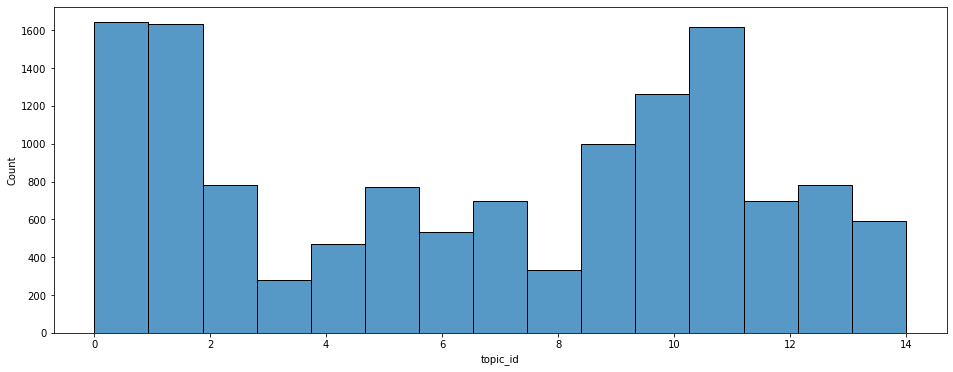

In [47]:
#Plotting the distribution of the topics next to the top words of each topic
plt.figure(figsize=(16, 6))
sns.histplot(data=df,x='topic_id',bins=15)
top_words_by_topic

## Conclusion
We can extract insights based on the top words of each topic. Based on it we can say that the most frequent topics in the department of justice are related to fraud, taxes, community issues and civil rights.<br>
I think the results make sense because:
1. The top words of each topic are closely related
2. Each topic has terminology that describes a kind of offense
3. All topics are mostly unique(except two of them which are related to taxes)

Next steps might be to have an expert in the law field to provide a more accurate list of stop words, but overall I think the model is pretty accurate.

In [49]:
#This library and methods to be used to save and restore the status of the kernel in a file
#import dill
#dill.load_session('notebook_env.db')
#dill.dump_session('notebook_env.db')